## Using PyTorch to build Neural Networks

In this notebook, we will leveraging the PyTorch Neural Network module (`torch.nn`)

In [ ]:
from IPython.display import Image as IPythonImage
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi


Tue Feb 18 15:40:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             33W /   70W |     158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print('PyTorch version:', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch version: 2.5.1+cu124
cuda


In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
  print('cpu')

Tesla T4


### Building a linear regression model

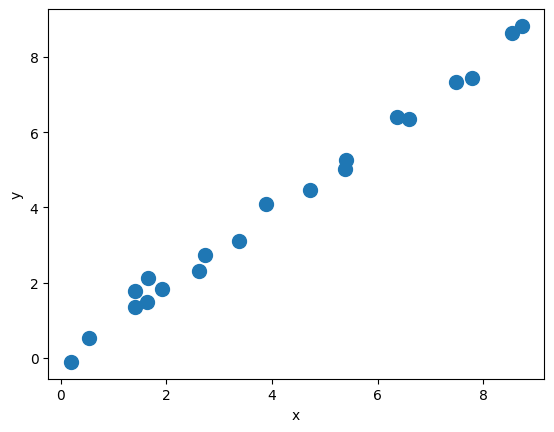

In [ ]:
np.random.seed(42)

X_train = np.random.uniform(0, 9, size=(20, 1)).reshape(-1, 1).astype('float32')
noise = np.random.normal(0, 0.25, size=(20, 1)).astype('float32')

y_train = 1.0*X_train+noise


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)

# On some computers the explicit cast to .float() is
# necessary
y_train = torch.from_numpy(y_train).float()

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
#----- TESTING -----#

def model(xb):
    # The @ operator denotes matrix multiplication (see PEP 465) / more readable than torch.matmul()
    return xb @ weight + bias

for x_batch, y_batch in train_dl:
  print(x_batch.shape)
  print(y_batch.shape)
  print(model(x_batch).shape)
  print(y_batch.squeeze(-1).shape) # Only removes the last dimension if its size is 1.
  break


torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2])
torch.Size([2])


In [ ]:
torch.manual_seed(1) # sets the seed to generate random numbers

#------------------------------------------------------------------------------------------------
# Initialize the weights
weight = torch.randn(1) # argument specify shape of the tensor

# The following sets the requires_grad attribute of the tensor to True;
# PyTorch will track operations on this tensor that has been created manually, and gradients will be computed for it during backpropagation
weight.requires_grad_() # You want to optimize the parameter 'weight'

# Initialize the bias tensor filled with zeros with a shape of (1,), and it sets requires_grad=True
bias = torch.zeros(1, requires_grad=True)

# Try also weight = torch.randn(1, requires_grad=True)
#------------------------------------------------------------------------------------------------


def loss_fn(output, target):
    return (output-target).pow(2).mean()

def model(xb):
    # The @ operator denotes matrix multiplication (see PEP 465) / more readable than torch.matmul()
    return xb @ weight + bias

learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        y_batch = y_batch.squeeze(-1)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        #print(pred.shape, loss.shape)
        #print('pred: ', pred)
        #print('loss: ', loss, '\n\n\n')

        #break

        loss.backward() # After calling loss.backward(), the gradients are computed and stored in the .grad attributes of the tensors

        with torch.no_grad(): #  used to disable temporarily gradient tracking during the parameter update, memory efficiency
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate

            # Zeroing gradients after updating; essential to reset their gradients to zero for the next iteration of the training loop
            # By default, PyTorch accumulates gradients. If you don’t zero the gradients, they will accumulate over multiple iterations (batches)
            weight.grad.zero_()
            bias.grad.zero_()

    #break

    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}') # item() method used to retrieve the value of a scalar tensor as a standard Python number


Epoch 0  Loss 6.5224
Epoch 10  Loss 32.5233
Epoch 20  Loss 1.0092
Epoch 30  Loss 7.2354
Epoch 40  Loss 7.3244
Epoch 50  Loss 1.4963
Epoch 60  Loss 0.8331
Epoch 70  Loss 1.0851
Epoch 80  Loss 0.6617
Epoch 90  Loss 0.2883
Epoch 100  Loss 0.1772
Epoch 110  Loss 0.1471
Epoch 120  Loss 0.0938
Epoch 130  Loss 0.0375
Epoch 140  Loss 0.1315
Epoch 150  Loss 0.1055
Epoch 160  Loss 0.0395
Epoch 170  Loss 0.0104
Epoch 180  Loss 0.1760
Epoch 190  Loss 0.1011


Final Parameters: 2.624, 3.977


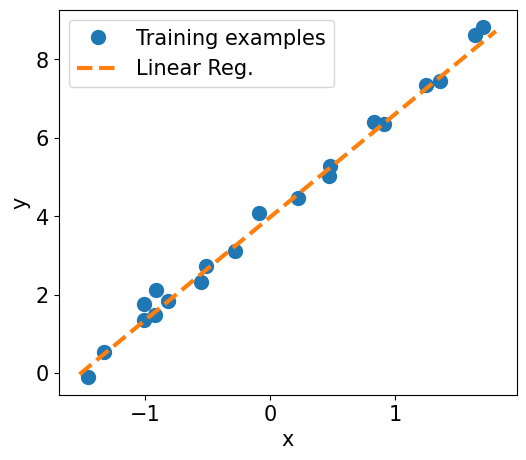

In [ ]:
print(f"Final Parameters: {weight.item():1.3f}, {bias.item():1.3f}")

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()
# In PyTorch, detach() is used to create a new tensor that shares the same data as the original tensor but is not part of the computation graph.
# This means that any operations on the detached tensor won’t be tracked for gradients.


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)


plt.show()

**Model training via `torch.nn` and `torch.optim` modules**

In [ ]:
# --- remind (1):
y_batch = torch.randn(2, 3, 1)
squeezed = y_batch.squeeze(-1)  # becomes [2, 3]
flattened = y_batch.view(-1)    # becomes [6]

print(y_batch)
print(squeezed)
print(flattened)

tensor([[[ 1.1124],
         [ 0.3314],
         [ 2.9973]],

        [[-0.2197],
         [-0.6007],
         [-0.4284]]])
tensor([[ 1.1124,  0.3314,  2.9973],
        [-0.2197, -0.6007, -0.4284]])
tensor([ 1.1124,  0.3314,  2.9973, -0.2197, -0.6007, -0.4284])


In [ ]:
# --- remind (2):

for x_batch, y_batch in train_dl:
  break

x_batch = x_batch.to(device)  # Move to GPU
y_batch = y_batch.to(device)

print(x_batch.shape)
print(x_batch)

print(model(x_batch).shape)
print(model(x_batch))
print(model(x_batch)[:,0].shape)
print(model(x_batch)[:,0])

print("\n\n\n\n\n")

torch.Size([2, 1])
tensor([[-0.8182],
        [-1.0060]], device='cuda:0')
torch.Size([2, 1])
tensor([[0.4615],
        [0.4039]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([2])
tensor([0.4615, 0.4039], device='cuda:0', grad_fn=<SelectBackward0>)








In [ ]:
import torch.nn as nn

input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size).to(device)



loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:

        x_batch = x_batch.to(device)  # Move to GPU
        y_batch = y_batch.to(device)  # Move to GPU

        # 1. Generate predictions
        pred = model(x_batch)[:,0]

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch.view(-1))  # view(-1) flattens it completely into a 1D tensor

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()

    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')



Epoch 0  Loss 18.5224
Epoch 10  Loss 20.7703
Epoch 20  Loss 0.3835
Epoch 30  Loss 0.5273
Epoch 40  Loss 2.9294
Epoch 50  Loss 1.2096
Epoch 60  Loss 0.5356
Epoch 70  Loss 1.0811
Epoch 80  Loss 0.3223
Epoch 90  Loss 0.0678
Epoch 100  Loss 0.0464
Epoch 110  Loss 0.1120
Epoch 120  Loss 0.2436
Epoch 130  Loss 0.1260
Epoch 140  Loss 0.0500
Epoch 150  Loss 0.0139
Epoch 160  Loss 0.0041
Epoch 170  Loss 0.0684
Epoch 180  Loss 0.0083
Epoch 190  Loss 0.0010


Final Parameters:, 2.6188, 3.9923


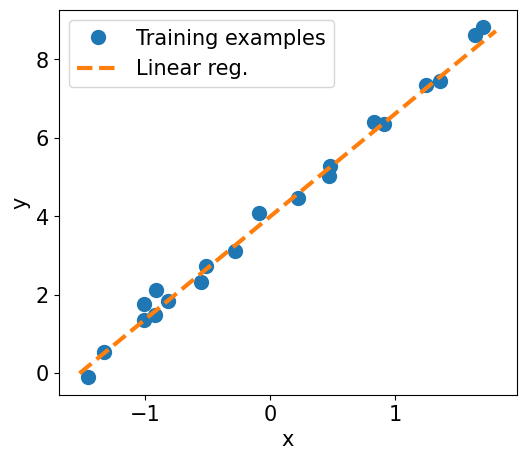

In [ ]:
print(f"Final Parameters:, {model.weight.item():1.4f}, {model.bias.item():1.4f}")

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm.to(device)).detach() #  detach() creates a new tensor deached from the computation graph; it shares the same data as the original tensor but does not require gradients



if(device.type == 'cuda'):

  # Move the test data and predictions to CPU for plotting
  X_test_norm = X_test_norm.cpu().numpy()  # Move to CPU
  y_pred = y_pred.cpu().numpy()  # Move to CPU

else:
  X_test_norm = X_test_norm.detach().numpy()
  y_pred = y_pred.detach().numpy()



fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm.detach().numpy(), y_train.detach().numpy(), 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)


plt.show()




---



### Exercise: train a regression model for the following polynomial *dataset*

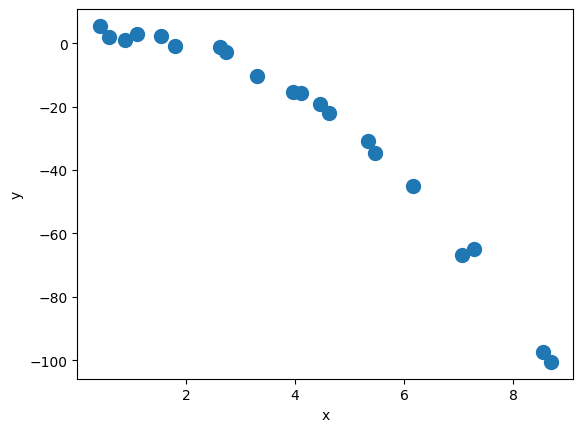

(20, 1) (20, 1)


In [ ]:
X_train = np.random.uniform(0, 9, size=(20, 1)).reshape(-1, 1).astype('float32')
noise = np.random.normal(0, 2., size=(20, 1)).astype('float32')

b = 5
a1 = 1.0
a2 = -1.5

y_train =  b + a1*X_train + a2*X_train**2 + noise


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

print(np.shape(X_train), np.shape(y_train))

Continue below...

<div style="margin: 3000px 0;"></div>



<div style="margin: 3000px 0;"></div>


<div style="margin: 3000px 0;"></div>


<div style="margin: 3000px 0;"></div>


<div style="margin: 3000px 0;"></div>




---



### (Sneak Preview of what is coming next...) Building an MLP for Classification

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
# For a list of all available layers http://pytorch.org/docs/stable/nn.html


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size).to(device)  # Move model to GPU


learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# Adam -Adaptive Moment Estimation- optimizer:
# It combines the benefits of AdaGrad and RMSProp
# More details can be found in https://github.com/cfteach/ml4hep/blob/main/gradient/gradient_descent.ipynb
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs


for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:

        # Move batch to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch) # the forward method is implictly called here
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)




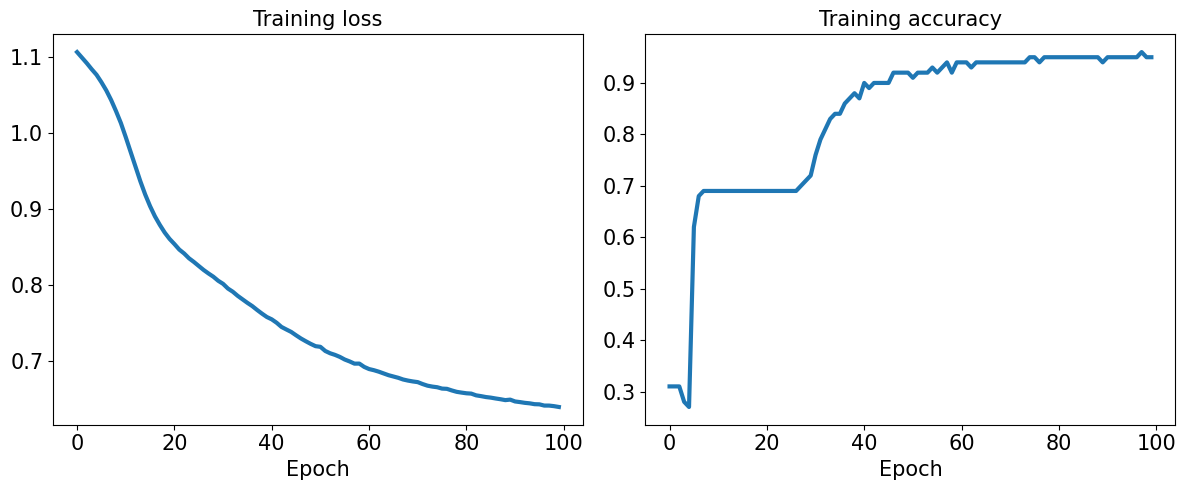

In [ ]:


if device.type == 'cuda':
  accuracy_hist = [acc.cpu() for acc in accuracy_hist]



fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()


**Accuracy for test dataset**

In [ ]:
# Normalize X_test
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float().to(device)  # Move to device

# Check if y_test is already a tensor and move it to the device
if isinstance(y_test, torch.Tensor):
    y_test = y_test.to(device)  # Move to device
else:
    y_test = torch.from_numpy(y_test).float().to(device)  # Convert from numpy if not already a tensor

# Make predictions
pred_test = model(X_test_norm)

# Move pred_test to CPU if necessary for processing, but ensure both are on the same device
if device.type == 'cuda':
    pred_test = pred_test.cpu()  # Move predictions to CPU

# Make sure y_test is on the same device as pred_test
if y_test.device != pred_test.device:
    y_test = y_test.cpu()  # Move y_test to CPU if needed

# Calculate accuracy
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')


Test Acc.: 0.9800


### Saving and reloading the trained model

In [ ]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [ ]:
model_new = torch.load(path)
model_new.eval()

<ipython-input-68-ddbeb3503457>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new = torch.load(path)


Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [ ]:
#if you want to save only the learned parameters

path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [ ]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))


<ipython-input-71-b21dbd0d4824>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800




---



### Exercise: train a classification model with 2 (or more) hidden layers

### **Appendix**

### Choosing activation functions for MLP


**Logistic function recap**

In [ ]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}')

P(y=1|x) = 0.888


In [ ]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas)

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [ ]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class)

Predicted class label: 0


**Estimating class probabilities in multiclass classification via the softmax function**

In [ ]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [ ]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

**Broadening the output spectrum using a hyperbolic tangent**

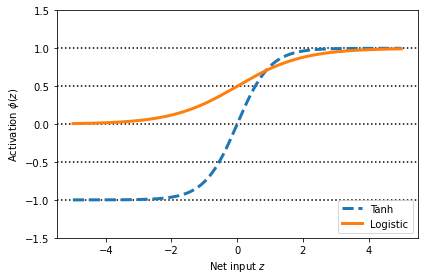

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

In [ ]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [ ]:
torch.tanh(torch.from_numpy(z))


tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [ ]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [ ]:
torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

**Rectified linear unit activation**

In [ ]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)